In [173]:
!pip install --upgrade -q git+https://github.com/MaxHalford/xam optuna

In [174]:
train_path = "../input/house-prices-advanced-regression-techniques/train.csv"
test_path = "../input/house-prices-advanced-regression-techniques/test.csv"

train_path_rf = "../input/imputedhousepricedata/train.csv"
test_path_rf = "../input/imputedhousepricedata/test.csv"

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import display
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from xam.feature_extraction import BayesianTargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [176]:
# import train, test data
X = pd.read_csv(train_path, index_col='Id')
X_test_full = pd.read_csv(test_path, index_col='Id')

X_rf = pd.read_csv(train_path_rf)
X_rf.columns = ['Id'] + list(X_rf.columns)[1:]
X_rf.set_index('Id', inplace=True)

X_test_full_rf = pd.read_csv(test_path_rf)
X_test_full_rf.columns = ['Id'] + list(X_test_full_rf.columns)[1:]
X_test_full_rf.set_index('Id', inplace=True)

display(X.head())
display(X_rf.head())
display(X_test_full.head())
display(X_test_full_rf.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,...,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,MnPrv,None,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,...,144,0,None,None,None,0,1,2010,WD,Normal


In [177]:
features = X.drop(columns=['SalePrice'])
target = X['SalePrice']

features_rf = X_rf.drop(columns=['SalePrice'])
target_rf = X_rf['SalePrice']

print(f'data type value count\n{X.dtypes.value_counts()}\n')
print(f'imputed data type value count\n{X_rf.dtypes.value_counts()}')

num_cols = features.select_dtypes(exclude=['object']).columns
cat_cols = features.select_dtypes(include=['object']).columns
num_cols_rf = features_rf.select_dtypes(exclude=['object']).columns
cat_cols_rf = features_rf.select_dtypes(include=['object']).columns

data type value count
object     43
int64      34
float64     3
dtype: int64

imputed data type value count
object     43
int64      35
float64     2
dtype: int64


In [178]:
# seperate features by type according to data description
fake_numeric = ['MSSubClass', 'MoSold']
ordinal = ['OverallQual', 'OverallCond']
ordinal_rf = ordinal
nominal = list(set(fake_numeric + list(cat_cols)) - set(ordinal))
nominal_rf = list(set(fake_numeric + list(cat_cols_rf)) - set(ordinal_rf))
numeric = list(set(num_cols) - set(ordinal) - set(nominal))
numeric_rf = list(set(num_cols_rf) - set(ordinal_rf) - set(nominal_rf))

In [179]:
def plot_na_count(features, title='NA count', figsize=(9,6), palette='Paired'):
    na_count = features.isna().sum()
    na_count = (na_count[na_count > 0] / na_count.sum()).sort_values(ascending=False)
    plt.figure(figsize=figsize)
    sns.barplot(y=na_count.index, x=na_count, palette=palette, orient='h')
    plt.title(title)
    plt.ylabel('proportion of count')
    plt.xlabel('column name')
    plt.show()

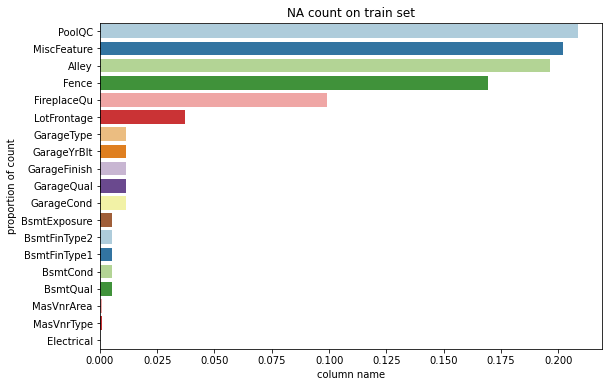

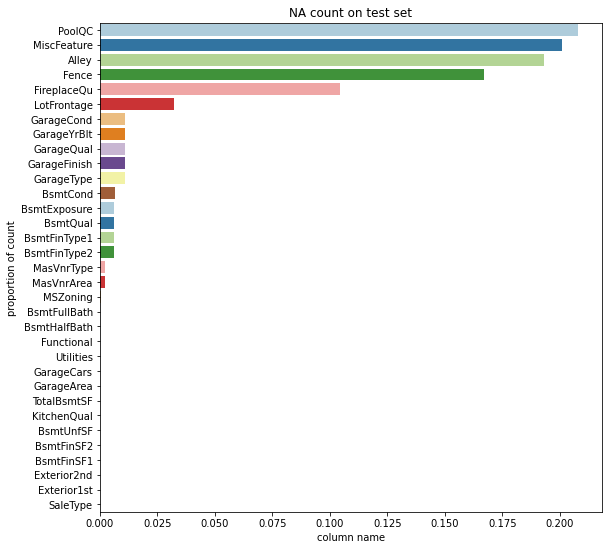

In [180]:
plot_na_count(features, title='NA count on train set')
plot_na_count(X_test_full, figsize=(9,9), title='NA count on test set')

In [181]:
none_list = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish',
             'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond',
             'BsmtQual', 'MasVnrType']
zero_list =  ['MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'TotalBsmtSF', 'BsmtFinSF2', 'BsmtFinSF1', 'GarageCars', 'GarageArea', 'BsmtUnfSF']
mode_list = ['Electrical', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual', 'Exterior1st', 'Exterior2nd']
median_list = ['LotFrontage']
    
imputed_cols = none_list + zero_list + mode_list + ["SaleType"]

imputer = ColumnTransformer(
        transformers=[
            ("none_imputer", SimpleImputer(strategy="constant", fill_value='None'), none_list),
            ("zero_imputer", SimpleImputer(strategy="constant", fill_value=0), zero_list),
            ("mode_imputer", SimpleImputer(strategy="most_frequent"), mode_list),
            ("sale_type_imputer", SimpleImputer(strategy="constant", fill_value="Oth"), imputed_cols[-1:])
        ],
        remainder='drop',
)

features[imputed_cols] = imputer.fit_transform(features)
X_test_full[imputed_cols] = imputer.transform(X_test_full)

# have missing values and seems irrelevant with house price
features.drop(columns=['GarageYrBlt'], inplace=True)
X_test_full.drop(columns=['GarageYrBlt'], inplace=True)
features_rf.drop(columns=['GarageYrBlt'], inplace=True)
X_test_full_rf.drop(columns=['GarageYrBlt'], inplace=True)

numeric.remove('GarageYrBlt')
numeric_rf.remove('GarageYrBlt')

In [182]:
log_target = np.log1p(target) # log transform target for ease of evaluation
log_target_rf = np.log1p(target_rf)

skewness of lot frontage: 2.163569142324884 



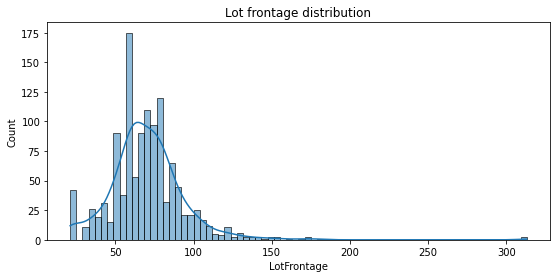

In [183]:
print('skewness of lot frontage:', features['LotFrontage'].skew(), '\n')
plt.figure(figsize=(9,4))
plt.title('Lot frontage distribution')
sns.histplot(features['LotFrontage'], kde=True)
plt.show()

In [184]:
# filling with street group median due to non-normality
frontage_median = features.groupby('Street')['LotFrontage'].median()
display(frontage_median)

features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].map(frontage_median)).fillna(0)
X_test_full['LotFrontage'] = X_test_full['LotFrontage'].fillna(X_test_full['LotFrontage'].map(frontage_median)).fillna(0)

Street
Grvl    81.0
Pave    69.0
Name: LotFrontage, dtype: float64

In [185]:
features[numeric] = features[numeric].astype('float')
X_test_full[numeric] = X_test_full[numeric].astype('float')

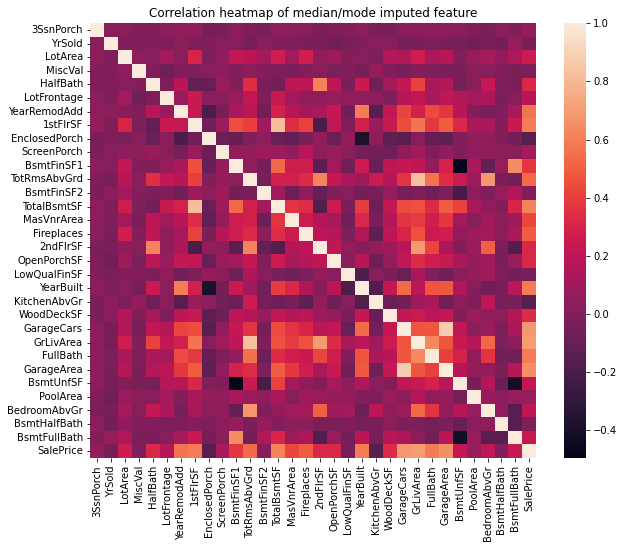

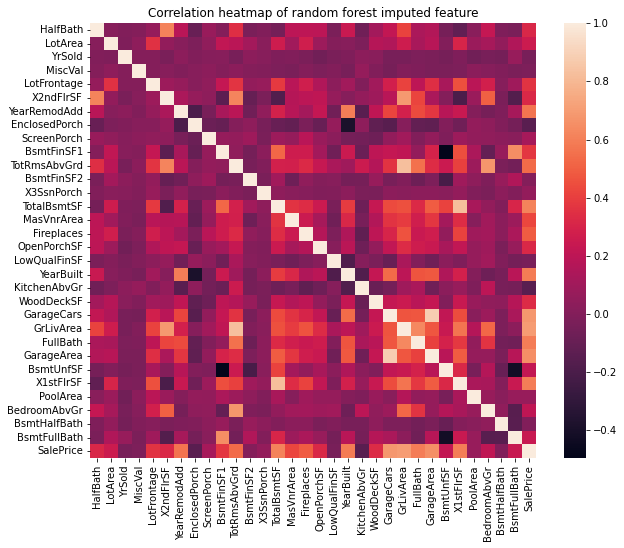

In [186]:
# plot correlation heat map
corr = pd.concat([features[numeric], log_target], axis=1).corr()
corr_rf = pd.concat([features_rf[numeric_rf], log_target_rf], axis=1).corr()

plt.figure(figsize=(10,8))
plt.title('Correlation heatmap of median/mode imputed feature')
sns.heatmap(corr)
plt.show()

plt.figure(figsize=(10,8))
plt.title('Correlation heatmap of random forest imputed feature')
sns.heatmap(corr_rf)
plt.show()

In [187]:
colin = (np.abs(corr) >= 0.7).sum() - 1
display(colin[colin>0].sort_values(ascending=False))
print('\n')
colin_rf = (np.abs(corr_rf) >= 0.7).sum() - 1
display(colin_rf[colin_rf>0].sort_values(ascending=False))

GrLivArea       2
1stFlrSF        1
TotRmsAbvGrd    1
TotalBsmtSF     1
GarageCars      1
GarageArea      1
SalePrice       1
dtype: int64

GrLivArea       2
TotRmsAbvGrd    1
TotalBsmtSF     1
GarageCars      1
GarageArea      1
X1stFlrSF       1
SalePrice       1
dtype: int64

In [188]:
copy = features.copy()
copy_t = X_test_full.copy()
copy_rf = features_rf.copy()
copy_t_rf = X_test_full_rf.copy()

# drop highly correlated features
for df in [copy, copy_t]:
    df.drop(columns=['1stFlrSF', 'GarageCars'], inplace=True)
    
for df in [copy_rf, copy_t_rf]:
    df.drop(columns=['X1stFlrSF', 'GarageCars'], inplace=True)

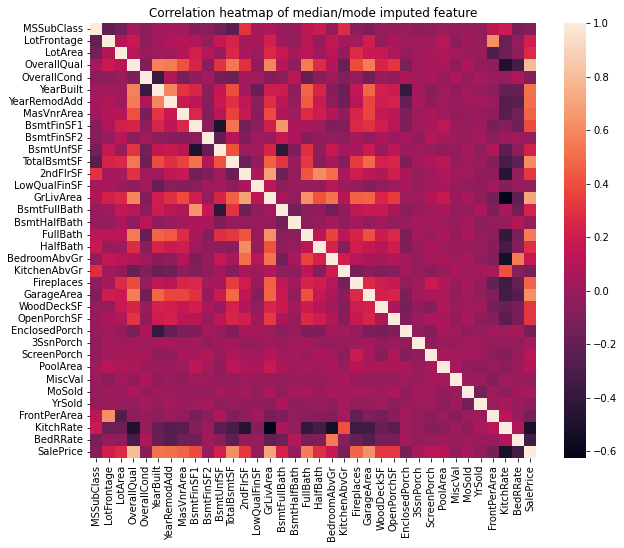

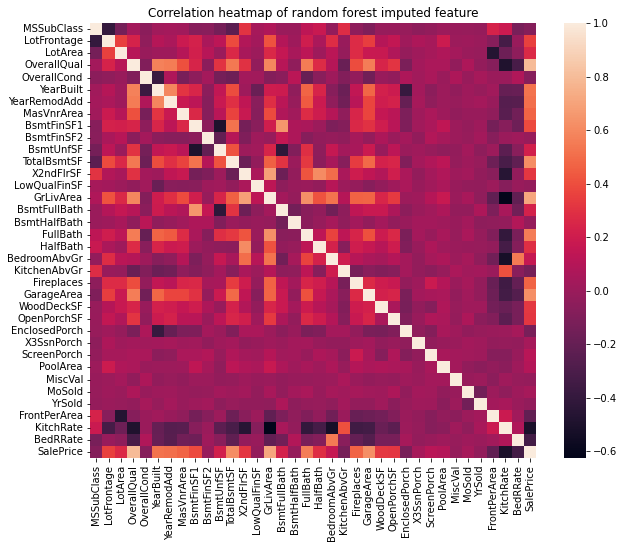

In [189]:
calc_frontperarea = lambda x: x['LotFrontage'] / x['LotArea']
calc_kitchenrate = lambda x: x['KitchenAbvGr'] / x['TotRmsAbvGrd']
calc_bedrate = lambda x: x['BedroomAbvGr'] / x['TotRmsAbvGrd']

for df in [copy, copy_t, copy_rf, copy_t_rf]:
    df['FrontPerArea'] = calc_frontperarea(df)
    df['KitchRate'] = calc_kitchenrate(df)
    df['BedRRate'] = calc_bedrate(df)

for df in [copy, copy_t, copy_rf, copy_t_rf]:
    df.drop(columns=['TotRmsAbvGrd'], inplace=True)

plt.figure(figsize=(10,8))
plt.title('Correlation heatmap of median/mode imputed feature')
sns.heatmap(pd.concat([copy, X['SalePrice']], axis=1).corr())
plt.show()
plt.figure(figsize=(10,8))
plt.title('Correlation heatmap of random forest imputed feature')
sns.heatmap(pd.concat([copy_rf, X_rf['SalePrice']], axis=1).corr())
plt.show()

In [190]:
# verify no colinearity
colin = (np.abs(copy.corr()) >= 0.7).sum() - 1
display(colin[colin>0].sort_values(ascending=False))
print('\n')
colin_rf = (np.abs(copy_rf.corr()) >= 0.7).sum() - 1
display(colin_rf[colin_rf>0].sort_values(ascending=False))

Series([], dtype: int64)

Series([], dtype: int64)

In [191]:
# encode categorical variable using target group mean
enc = BayesianTargetEncoder(
    columns=nominal,
    prior_weight=5, # smoothing to prevent overfitting
    suffix=''
)

features.loc[:,nominal] = enc.fit_transform(features.loc[:,nominal], log_target)
X_test_full.loc[:,nominal] = enc.transform(X_test_full.loc[:,nominal])

enc_rf = BayesianTargetEncoder(
    columns=nominal_rf,
    prior_weight=5,
    suffix=''
)

features_rf.loc[:,nominal_rf] = enc_rf.fit_transform(features_rf.loc[:,nominal_rf], log_target_rf)
X_test_full_rf.loc[:,nominal_rf] = enc_rf.transform(X_test_full_rf.loc[:,nominal_rf])

In [192]:
# feature standardization
scaler = StandardScaler()
features[numeric] = scaler.fit_transform(features[numeric])
X_test_full[numeric] = scaler.fit_transform(X_test_full[numeric])

scaler_rf = StandardScaler()
features_rf[numeric_rf] = scaler_rf.fit_transform(features_rf[numeric_rf])
X_test_full_rf[numeric_rf] = scaler_rf.fit_transform(X_test_full_rf[numeric_rf])

In [193]:
n_splits = 5
def do_cv(X, y, model):
    means = []
    kf = KFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = model.fit(X_train, y_train)
        rmsle = mean_squared_error(y_test, model.predict(X_test))
        means.append(rmsle)
    return np.average(means)

In [194]:
def objective_lasso(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-5, 1e0)
    )
    model = Lasso(**params, max_iter = 10000000)
    return do_cv(features, log_target, model)

def objective_lasso_rf(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-5, 1e0)
    )
    model = Lasso(**params, max_iter = 10000000)
    return do_cv(features_rf, log_target_rf, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=150, show_progress_bar=True)

study_lasso_rf = optuna.create_study(direction='minimize')
study_lasso_rf.optimize(objective_lasso_rf, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

In [195]:
print('best lasso regression rmsle score:', np.sqrt(study_lasso.best_value))
print('best random forest imputed lasso regression rmsle score:', np.sqrt(study_lasso_rf.best_value))

best lasso regression rmsle score: 0.1404822417219589
best random forest imputed lasso regression rmsle score: 0.14147926407589265


In [196]:
lasso_model = Lasso(**study_lasso.best_params).fit(features, log_target)
lasso_pred = np.expm1(lasso_model.predict(X_test_full))
lasso_pred

array([110766.39452804, 150194.97637965, 170924.47482416, ...,
       174260.59427157, 116257.85151352, 219704.41901036])

In [103]:
def objective_ridge(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-5, 1e0)
    )
    model = Ridge(**params, max_iter = 10000000)
    return do_cv(features, log_target, model)

def objective_ridge_rf(trial):
    params = dict(
           alpha=trial.suggest_float('alpha', 1e-5, 1e0)
    )
    model = Ridge(**params, max_iter = 10000000)
    return do_cv(features_rf, log_target_rf, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=150, show_progress_bar=True)

study_ridge_rf = optuna.create_study(direction='minimize')
study_ridge_rf.optimize(objective_ridge_rf, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

In [104]:
print('best ridge regression rmsle score:', np.sqrt(study_ridge.best_value))
print('best random forest imputed ridge regression rmsle score:', np.sqrt(study_ridge_rf.best_value))

best ridge regression rmsle score: 0.13846025342876206
best random forest imputed ridge regression rmsle score: 0.13812621366915337


In [106]:
ridge_model = Ridge(**study_ridge_rf.best_params).fit(features_rf, log_target_rf)
ridge_pred = np.expm1(ridge_model.predict(X_test_full_rf))
ridge_pred

array([108859.715569  , 154989.99441133, 170143.9611963 , ...,
       171000.66474374, 116829.96715135, 218303.37660446])

In [108]:
def objective_svr(trial):
    params = dict(
            C=trial.suggest_float('C', 1e-2, 1e3)
    )
    model = SVR(**params)
    return do_cv(features, log_target, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

In [109]:
def objective_svr_rf(trial):
    params = dict(
            C=trial.suggest_float('C', 1e-2, 1e3)
    )
    model = SVR(**params)
    return do_cv(features_rf, log_target_rf, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_svr_rf = optuna.create_study(direction='minimize')
study_svr_rf.optimize(objective_svr_rf, n_trials=150, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/150 [00:00<?, ?it/s]

In [110]:
print('best svr rmsle score:', np.sqrt(study_svr.best_value))
print('best random forest imputed svr rmsle score:', np.sqrt(study_svr_rf.best_value))

best svr rmsle score: 0.12237158752130012
best random forest imputed svr rmsle score: 0.12187919550784534


In [111]:
svr_model = SVR(**study_svr_rf.best_params).fit(features_rf, log_target_rf)
svr_pred = np.expm1(svr_model.predict(X_test_full_rf))
svr_pred

array([115291.19988572, 143908.41225973, 183839.60305942, ...,
       178654.48446477, 115452.62059386, 226720.35946725])

In [112]:
def objective_gdb(trial):
    params = dict(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 5e-2, 3e-1),
        max_depth=trial.suggest_int('max_depth', 2, 6)
    )
    model = GradientBoostingRegressor(**params)
    return do_cv(features, log_target, model)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study_gdb = optuna.create_study(direction='minimize')
study_gdb.optimize(objective_gdb, n_trials=75, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/75 [00:00<?, ?it/s]

In [113]:
def objective_gdb_rf(trial):
    params = dict(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 5e-2, 3e-1),
        max_depth=trial.suggest_int('max_depth', 2, 6)
    )
    model = GradientBoostingRegressor(**params)
    return do_cv(features_rf, log_target_rf, model)
study_gdb_rf = optuna.create_study(direction='minimize')
study_gdb_rf.optimize(objective_gdb_rf, n_trials=75, show_progress_bar=True)

/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/75 [00:00<?, ?it/s]

In [114]:
print('best gdb rmsle score:', np.sqrt(study_gdb.best_value))
print('best random forest imputed gdb rmsle score:', np.sqrt(study_gdb_rf.best_value))

best gdb rmsle score: 0.12106211797106461
best random forest imputed gdb rmsle score: 0.12161931488221508


In [152]:
gdb_model = GradientBoostingRegressor(**study_gdb.best_params).fit(features, log_target)
gdb_pred = np.expm1(gdb_model.predict(X_test_full))
gdb_pred

array([127425.82279741, 161581.52108884, 193403.93841931, ...,
       152351.05902599, 122912.2505422 , 224325.13709098])

In [197]:
combined = 0.6 * np.log1p(svr_pred) + 0.3 * np.log1p(gdb_pred) + 0.1 * np.log1p(ridge_pred)
np.expm1(combined)

array([118124.9544234 , 150106.53047757, 185218.64119532, ...,
       169574.9832965 , 117781.276063  , 225145.74353912])

In [198]:
pd.DataFrame({
    'Id': X_test_full.index,
    'SalePrice': np.expm1(combined)
}).to_csv('submission.csv', index=False)

In [199]:
# export models
with open('ridge.pkl', 'wb') as fp:
    pickle.dump(ridge_model, fp)

with open('svr.pkl', 'wb') as fp:
    pickle.dump(svr_model, fp)
    
with open('gdb.pkl', 'wb') as fp:
    pickle.dump(gdb_model, fp)